In [1]:
try:
    import tinygp
except ImportError:
    !pip install -q tinygp

try:
    import george
except ImportError:
    !pip install -q george

# Comparison with george

In [2]:
!nvidia-smi

Fri Jul 23 11:49:00 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:61:00.0 Off |                    0 |
| N/A   36C    P0    70W / 300W |      0MiB / 32510MiB |     10%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from functools import partial

import numpy as np
import matplotlib.pyplot as plt

import jax
from jax import config
import jax.numpy as jnp

import george
import tinygp

config.update("jax_enable_x64", True)

In [4]:
sigma = 1.5
rho = 2.5
jitter = 0.1

random = np.random.default_rng(49382)
x = np.sort(random.uniform(0, 10, 10_000))
y = np.sin(x) + jitter * random.normal(0, 1, len(x))


def george_loglike(x, y):
    kernel = sigma ** 2 * george.kernels.Matern32Kernel(rho ** 2)
    gp = george.GP(kernel)
    gp.compute(x, jitter)
    return gp.log_likelihood(y)


def tinygp_loglike(x, y):
    kernel = sigma ** 2 * tinygp.kernels.Matern32(rho)
    gp = tinygp.GaussianProcess(kernel, x, diag=jitter ** 2)
    return gp.condition(y)


tinygp_loglike_cpu = jax.jit(tinygp_loglike, backend="cpu")
tinygp_loglike_gpu = jax.jit(tinygp_loglike, backend="gpu")

In [5]:
ns = [10, 100, 1_000, 10_000]
george_time = []
cpu_time = []
gpu_time = []
for n in ns:
    print(n)

    # Run the JAX versions once each to make sure they get JIT'd
    args = x[:n], y[:n]
    tinygp_loglike_cpu(*args).block_until_ready()
    tinygp_loglike_gpu(*args).block_until_ready()
    
    results = %timeit -o george_loglike(*args)
    george_time.append(results.average)
    
    results = %timeit -o tinygp_loglike_cpu(*args).block_until_ready()
    cpu_time.append(results.average)
    
    results = %timeit -o tinygp_loglike_gpu(*args).block_until_ready()
    gpu_time.append(results.average)

10
373 µs ± 7.72 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
13.9 µs ± 42.9 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
108 µs ± 215 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
100
890 µs ± 683 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
396 µs ± 902 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
191 µs ± 397 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1000
23.2 ms ± 68.1 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
29.2 ms ± 558 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
1.55 ms ± 432 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
10000
3.55 s ± 51.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.96 s ± 21.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
84.1 ms ± 32.9 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


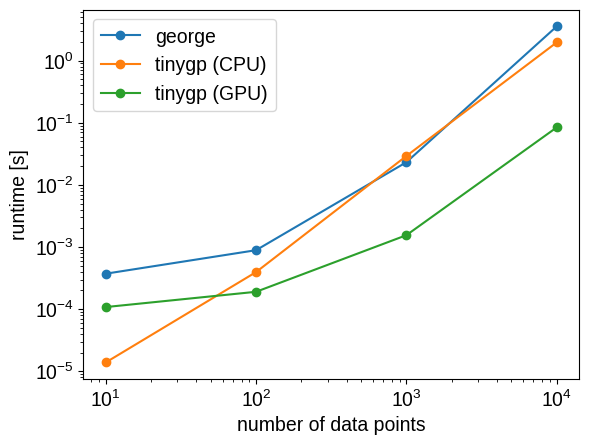

In [9]:
plt.loglog(ns, george_time, "o-", label="george")
plt.loglog(ns, cpu_time, "o-", label="tinygp (CPU)")
plt.loglog(ns, gpu_time, "o-", label="tinygp (GPU)")
# plt.loglog(ns, 2 * np.array(ns) ** 3 / ns[-1] ** 3 * george_time[-1], ":k")
plt.legend()
plt.xlabel("number of data points")
plt.ylabel("runtime [s]");